# Organisation des données.

Sur le bureau h (Desktop) :
    - Fichier csv : "TrainingSet_20aimVO.csv"
    - Dossier : "TrainingSetImagesDir"
    - Dossier : "TestSetImagesDir"
    
Contenu du fichier csv "TrainingSet_20aimVO.csv".
    - Colonne A : image_filename
    - Colonne B : class_number
    - Tableau trié par ordre croissant selon le nom des images.
Ce que tu dois voir dans la colonne A :
    - im_0_0.png
    - im_0_1.png
    - im_0_10.png
    - im_0_11.png
    - ...
Ce que tu dois voir dans la colonne B :
    - 0
    - 0
    - 2
    - 1
    - ...

# Description des variables d'entrée et de sortie.

### Inputs.

Images obtenues à partir de 61 patients. Chaque image est une matrice 2D (images en noir et blanc).

### Outputs.

La sortie associée à une entrée est un entier de 0 à 3. On associe à chaque entier un stade de développement du cancer de l'oesophage.

  - 0 : "Squamous_Epithelium"
  - 1 : "Intestinal_metaplasia"
  - 2 : "Gastric_metaplasia"
  - 3 : "Dysplasia_and_Cancer"

### Nombres d'échantillons.

Il y a un total de 11161 images obtenues à partir de 61 patients.

### Découpage train-test.

Le découpage train-test est déjà réalisé. On a un ensemble d'apprentissage et deux ensembles de test (80 % - 10 % - 10 %).

# Idées.

- Architectures CNNs type : LeNet5, AlexNet, VGG-16...
https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d

- Modifier les images pour obtenir des données plus intéressantes.

- Augmentation artificielle des données.

- Cross-validation pour le choix des paramètres du réseau de neurones.


# Importation des modules.

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import keras

from PIL import Image # used for loading images
import imageio # used for writing images

Using TensorFlow backend.


In [2]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, adam, Adadelta
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.utils import plot_model 
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D

In [3]:
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten
import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler

# Importation des données d'apprentissage.

In [4]:
# Lecture du tableau Excel contenant la classe associée à chaque image.

#file_path =  "C:\\Users\\FEU49\\Desktop\\"
file_path =  "C:\\Users\\usuario\\Desktop\\Data challenge\\"
data_path = file_path + "TrainingSet_20aimVO.csv"
features_names = pd.read_csv(data_path)
print(features_names)

     image_filename  class_number
0        im_0_0.png             0
1        im_0_1.png             0
2       im_0_10.png             2
3       im_0_11.png             1
4       im_0_12.png             1
5       im_0_13.png             2
6       im_0_14.png             1
7       im_0_15.png             1
8       im_0_17.png             1
9       im_0_18.png             3
10      im_0_19.png             1
11       im_0_2.png             3
12      im_0_22.png             3
13      im_0_23.png             1
14      im_0_24.png             2
15      im_0_25.png             3
16      im_0_29.png             3
17       im_0_3.png             3
18      im_0_30.png             1
19      im_0_31.png             0
20      im_0_32.png             1
21      im_0_34.png             3
22      im_0_35.png             1
23      im_0_36.png             0
24       im_0_4.png             0
25      im_0_40.png             3
26      im_0_41.png             0
27      im_0_42.png             3
28      im_0_4

In [5]:
# Récupération des classes.
# Tableau Excel trié dans l'ordre croissant par rapport au nom des images.

Y_train = features_names.values[:,1]
print(Y_train)

# On vérifie qu'on a le nombre d'éléments attendu.

print("Nombre d'instances dans l'ensemble d'apprentissage : ", len(Y_train))

# Conversion. One-hot encoding.

Y_train = to_categorical(Y_train)
print(Y_train)

[0 0 2 ... 3 0 1]
Nombre d'instances dans l'ensemble d'apprentissage :  9446
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


In [6]:
# Fonction donnant des informations sur les dimensions des images.

def data_size(DIR):
    heights = []
    widths = []
    for img in os.listdir(DIR): 
        path = os.path.join(DIR, img)
        data = np.array(Image.open(path)) #PIL Image library
        heights.append(data.shape[0])
        widths.append(data.shape[1])
        avg_height = sum(heights) / len(heights)
        avg_width = sum(widths) / len(widths)
    print("Average Height: " + str(avg_height))
    print("Max Height: " + str(max(heights)))
    print("Min Height: " + str(min(heights)))
    print('\n')
    print("Average Width: " + str(avg_width))
    print("Max Width: " + str(max(widths)))
    print("Min Width: " + str(min(widths)))

In [7]:
def load_training_data(DIR, height, width):
    train_data = []
    for img in os.listdir(DIR) :
        path = os.path.join(DIR, img)
        img = Image.open(path)
        img = img.convert('L')
        img = img.resize((height, width)) #, Image.ANTIALIAS
        train_data.append(np.array(img))
    return train_data

In [8]:
data_path = file_path + "\\TrainingSetImagesDir"

data_size(data_path)

Average Height: 519.0
Max Height: 519
Min Height: 519


Average Width: 521.0
Max Width: 521
Min Width: 521


In [59]:
height = 100
width = 100
DIR = file_path + "\\TrainingSetImagesDir"

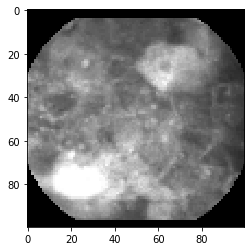

In [60]:
X_train = load_training_data(DIR, height, width)
plt.imshow(X_train[43], cmap = 'gist_gray') 
plt.imshow(X_train[1], cmap = 'gist_gray') 

[0. 0. 1. 0.]


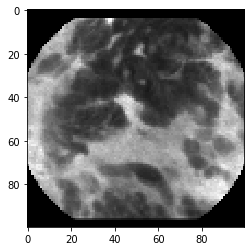

In [61]:
plt.imshow(X_train[430], cmap = 'gist_gray') 
print(Y_train[430])

In [62]:
num_channel = 1
X_train = np.array(X_train)
X_train = X_train.reshape(len(X_train), height, width, num_channel)
repeat=np.concatenate((X_train, X_train), axis=3)
X_TRAIN=np.concatenate((repeat, X_train), axis=3)

In [63]:
print(X_train.shape)
print(X_TRAIN.shape)
print(X_train[20][20][29][0])

(9446, 100, 100, 1)
(9446, 100, 100, 3)
58


# Modèle n°1 .

In [18]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(height, width, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation = 'softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 49, 49, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 23, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)      

# Modèle n°2 . C'est le modele 1 avec un autre bloc Conv2D/MaxPooling/Batch

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 100, 100, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 25, 25, 64)        256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 25, 32)       

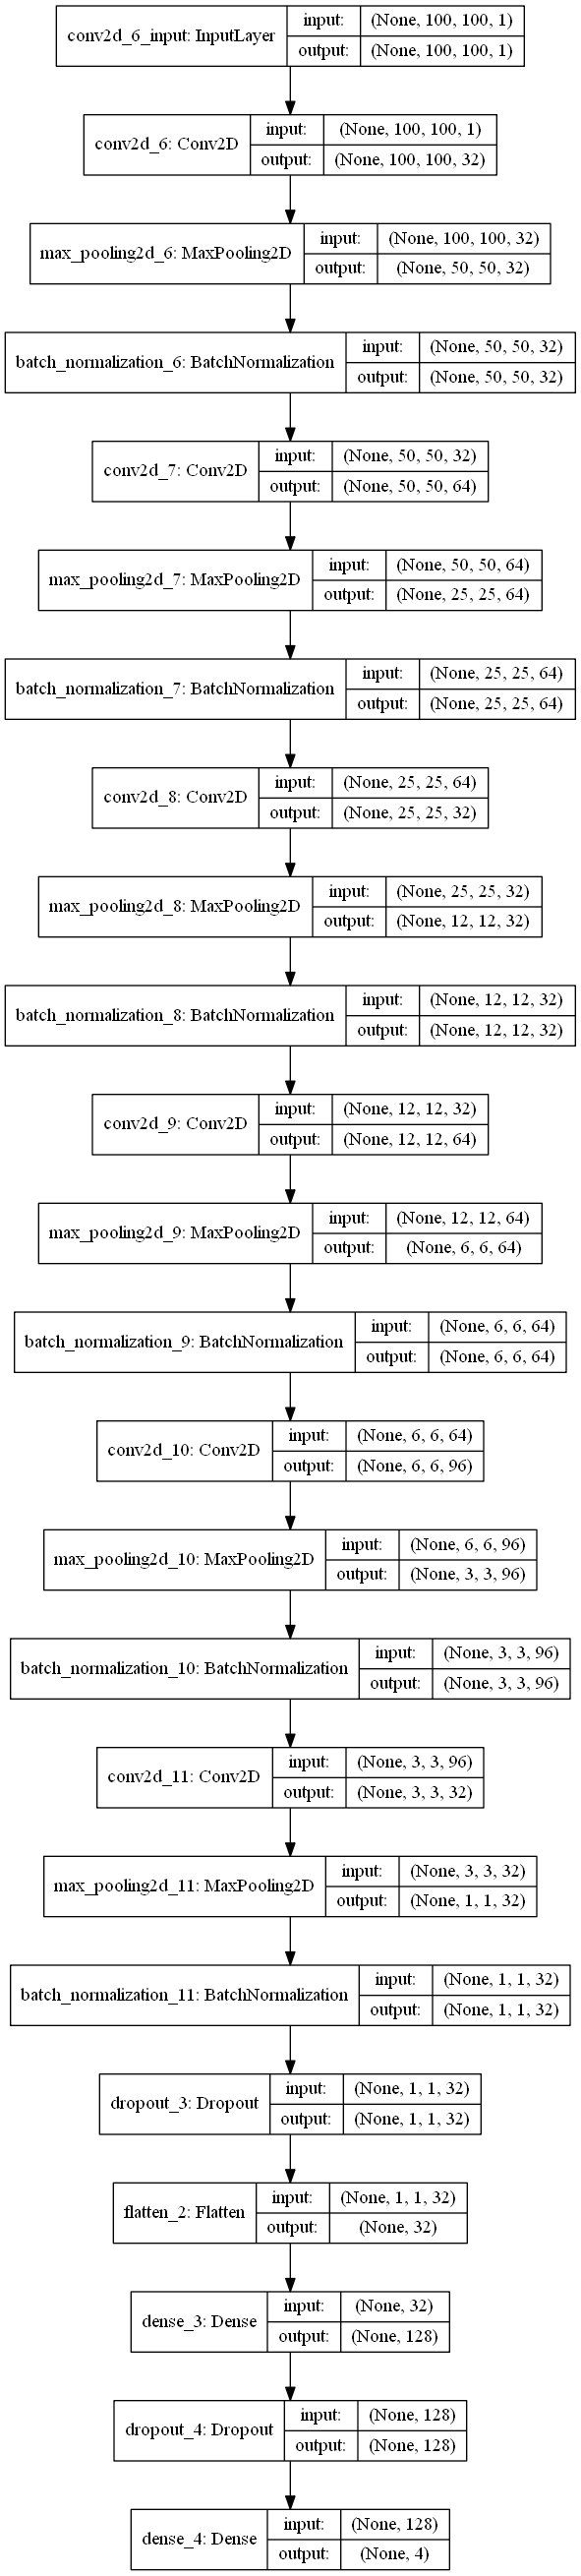

In [23]:
from keras import initializers
mon_init1 = initializers.RandomNormal(mean=0.0, stddev=0.05)

model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), padding='same', activation='relu', input_shape=(height, width, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation = 'softmax'))
model.summary()

plot_model(model, show_shapes=True, to_file='Model.png')

# Modèle n°3 "VGG CNN avec deux blocs".

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 98, 98, 32)        320       
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 24, 24, 64)      

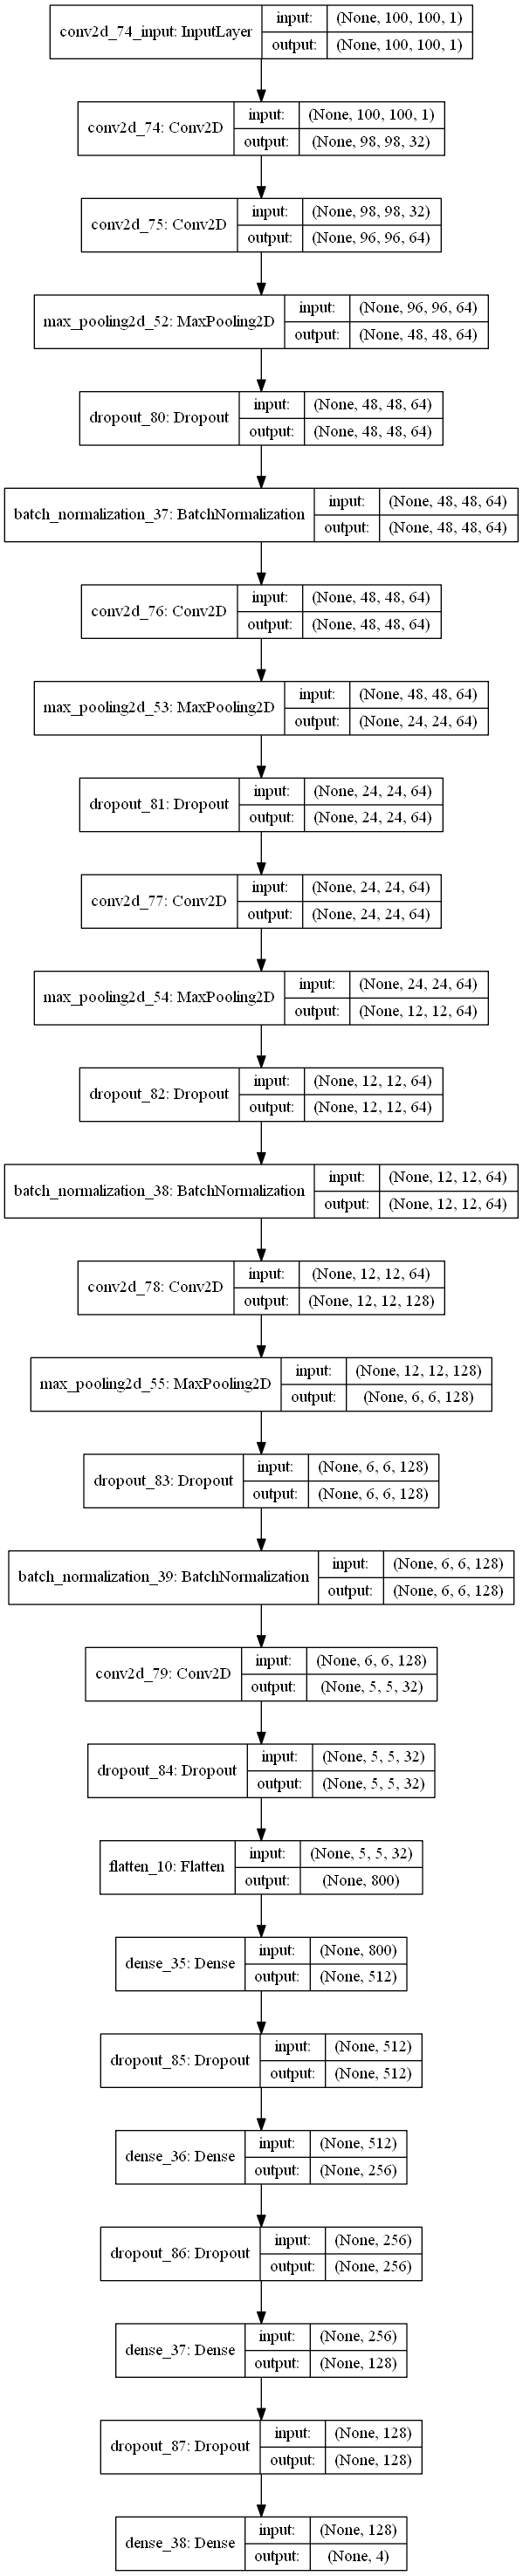

In [64]:
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten
import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler

model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(height, width, 1)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size = (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size = (2, 2), activation='relu'))

model.add(Dropout(0.4))
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(4, activation='softmax'))
model.summary()

plot_model(model, show_shapes=True, to_file='Model_2.png')

In [65]:
initial_lrate = 0.1

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.99999
    epochs_drop = 5
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
sgd = SGD(lr=initial_lrate, momentum=0.9)

es_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)
lr_sc = LearningRateScheduler(decay, verbose=1)
es_callback=[lr_sc]

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history1=model.fit(X_train, Y_train, batch_size = 100, epochs = 100 ,validation_split = 0.05,verbose=1,callbacks=es_callback)

Train on 8973 samples, validate on 473 samples
Epoch 1/100
8973/8973 [==============================] - 404s 45ms/step - loss: 1.3381 - accuracy: 0.3658 - val_loss: 1.2773 - val_accuracy: 0.4038
Epoch 2/100
8973/8973 [==============================] - 354s 39ms/step - loss: 1.2895 - accuracy: 0.3794 - val_loss: 1.2786 - val_accuracy: 0.4038
Epoch 3/100
8973/8973 [==============================] - 325s 36ms/step - loss: 1.2890 - accuracy: 0.3688 - val_loss: 1.2780 - val_accuracy: 0.4038
Epoch 4/100
8973/8973 [==============================] - 363s 40ms/step - loss: 1.2890 - accuracy: 0.3792 - val_loss: 1.2811 - val_accuracy: 0.3235
Epoch 5/100
8973/8973 [==============================] - 316s 35ms/step - loss: 1.2897 - accuracy: 0.3697 - val_loss: 1.2794 - val_accuracy: 0.4038
Epoch 6/100
8973/8973 [==============================] - 319s 36ms/step - loss: 1.2881 - accuracy: 0.3771 - val_loss: 1.2788 - val_accuracy: 0.4038
Epoch 7/100
8973/8973 [==============================] - 312s 35m

KeyboardInterrupt: 

# Modèle n°4 "VGG CNN avec 5 blocs".

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_121 (Conv2D)          (None, 100, 100, 64)      640       
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_110 (MaxPoolin (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 25, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_111 (MaxPoolin (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 12, 12, 128)     

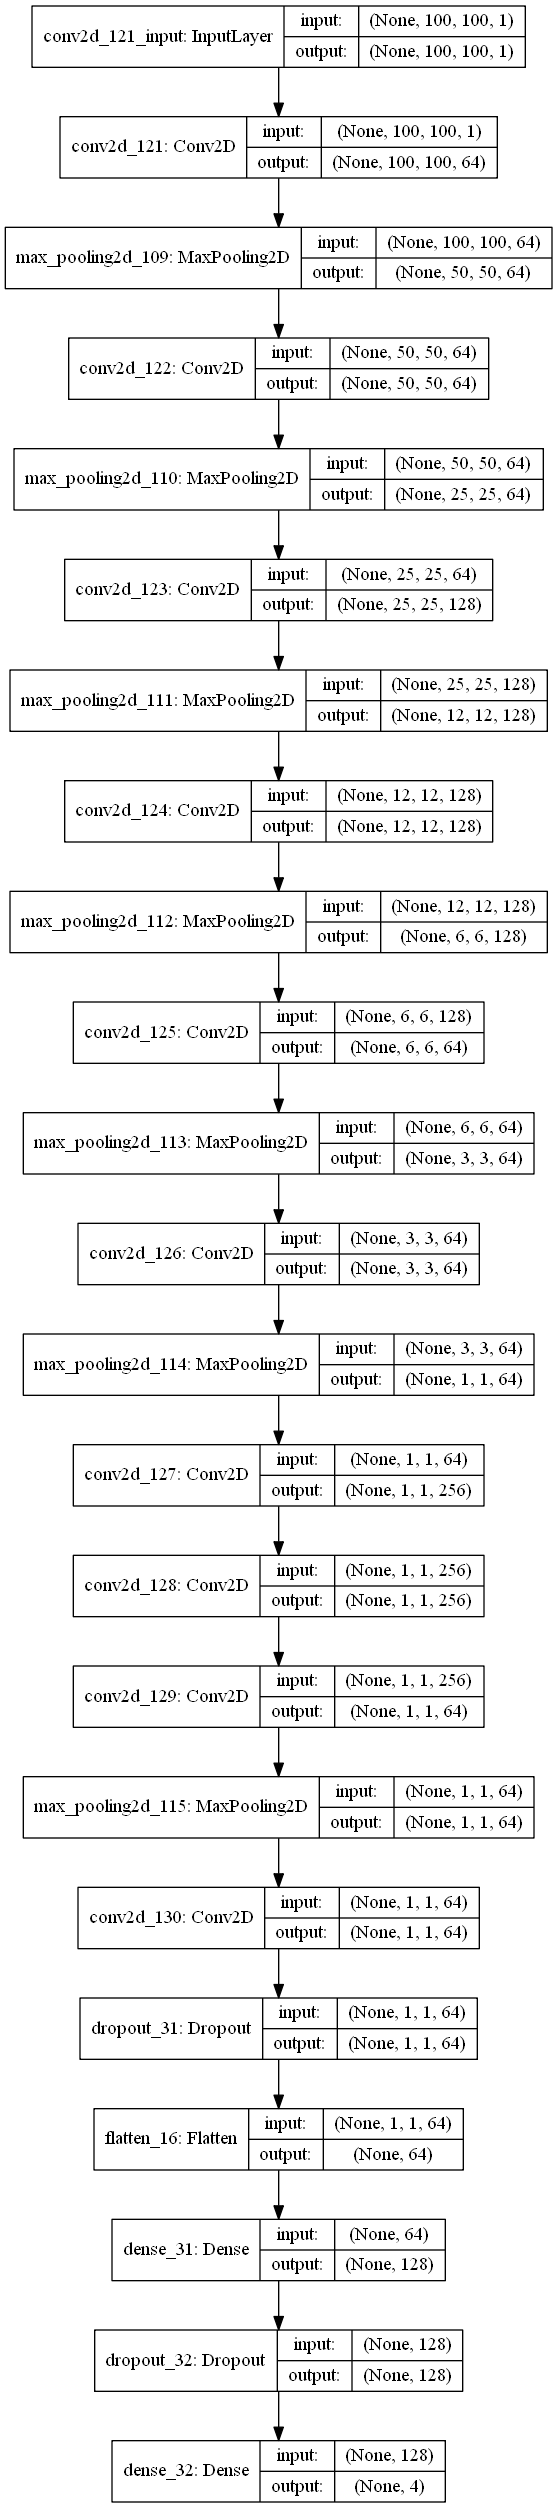

In [54]:
model = Sequential()

#premier bloc
model.add(Conv2D(64, kernel_size = (3, 3), padding='same', activation='relu', input_shape=(height, width, 1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#deuxieme bloc
model.add(Conv2D(128, kernel_size = (3, 3), padding='same', activation='relu', input_shape=(height, width, 1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#troiieme bloc
model.add(Conv2D(64, kernel_size = (3, 3), padding='same', activation='relu', input_shape=(height, width, 1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#quatrieme bloc
model.add(Conv2D(256, kernel_size = (3, 3), padding='same', activation='relu', input_shape=(height, width, 1)))
#model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#cinquieme bloc
model.add(Conv2D(64, kernel_size = (3, 3), padding='same', activation='relu', input_shape=(height, width, 1)))
model.add(MaxPooling2D(pool_size=(1,1), strides=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
#model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation = 'softmax'))
model.summary()

plot_model(model, show_shapes=True, to_file='Vgg2.png')

# Modèle n°5 "CNN A from "very deep CNN" ".

In [15]:
from keras import initializers
mon_init1 = initializers.RandomNormal(mean=0.0, stddev=0.05)
model = Sequential()

#premier bloc
model.add(Conv2D(64, kernel_size = (3, 3), padding='same', activation='relu', input_shape=(height, width, 1),kernel_initializer=mon_init1))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#deuxieme bloc
model.add(Conv2D(128, kernel_size = (3, 3), padding='same', activation='relu',kernel_initializer=mon_init1))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#troiieme bloc
model.add(Conv2D(256, kernel_size = (3, 3), padding='same', activation='relu',kernel_initializer=mon_init1))
model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu',kernel_initializer=mon_init1))
model.add(MaxPooling2D(pool_size=(1,1), strides=(2,2)))

#quatrieme bloc
model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(1,1), strides=(2,2)))

#cinquieme bloc
model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(1,1), strides=(2,2)))

#on utilise flatten pour preparer l'input pour les couches denses
model.add(Flatten())
model.add(Dense(4096, activation='relu',kernel_initializer=mon_init1))
model.add(Dense(4096, activation='relu',kernel_initializer=mon_init1))
model.add(Dense(1000, activation='relu',kernel_initializer=mon_init1))
model.add(Dropout(0.5))
model.add(Dense(4, activation = 'softmax'))
model.summary()

#plot_model(model, show_shapes=True, to_file='CNN_A.png')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 100, 100, 64)      640       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 25, 25, 256)       295168    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 25, 25, 256)       590080    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 13, 256)      

# Evaluation

In [21]:
sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True) 
model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history=model.fit(X_train, Y_train, batch_size = 50, epochs = 100, verbose = 1) ;

Epoch 1/100
9446/9446 [==============================] - 278s 29ms/step - loss: 1.3527 - accuracy: 0.3534
Epoch 2/100
9446/9446 [==============================] - 187s 20ms/step - loss: 1.2939 - accuracy: 0.3750
Epoch 3/100
9446/9446 [==============================] - 189s 20ms/step - loss: 1.2898 - accuracy: 0.3715
Epoch 4/100
9446/9446 [==============================] - 189s 20ms/step - loss: 1.2879 - accuracy: 0.3798
Epoch 5/100
9446/9446 [==============================] - 200s 21ms/step - loss: 1.2866 - accuracy: 0.3815
Epoch 6/100
9446/9446 [==============================] - 187s 20ms/step - loss: 1.2854 - accuracy: 0.3778
Epoch 7/100
9446/9446 [==============================] - 189s 20ms/step - loss: 1.2841 - accuracy: 0.3791
Epoch 8/100
9446/9446 [==============================] - 185s 20ms/step - loss: 1.2833 - accuracy: 0.3850
Epoch 9/100
9446/9446 [==============================] - 191s 20ms/step - loss: 1.2826 - accuracy: 0.3802
Epoch 10/100
9446/9446 [======================

In [31]:
#es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True) 
model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history=model.fit(X_train, Y_train, batch_size = 50, epochs = 100,validation_split = 0.2,verbose = 1)#,callbacks=[es_callback]) 

Train on 7556 samples, validate on 1890 samples
Epoch 1/100
7556/7556 [==============================] - 1424s 189ms/step - loss: 1.3207 - accuracy: 0.3649 - val_loss: 1.3249 - val_accuracy: 0.3693
Epoch 2/100
7556/7556 [==============================] - 245s 32ms/step - loss: 1.2861 - accuracy: 0.3729 - val_loss: 1.3137 - val_accuracy: 0.3772
Epoch 3/100
7556/7556 [==============================] - 245s 32ms/step - loss: 1.2803 - accuracy: 0.3813 - val_loss: 1.3172 - val_accuracy: 0.3772
Epoch 4/100
7556/7556 [==============================] - 243s 32ms/step - loss: 1.2795 - accuracy: 0.3810 - val_loss: 1.3201 - val_accuracy: 0.3778
Epoch 5/100
7556/7556 [==============================] - 240s 32ms/step - loss: 1.2799 - accuracy: 0.3772 - val_loss: 1.3167 - val_accuracy: 0.3772
Epoch 6/100
7556/7556 [==============================] - 242s 32ms/step - loss: 1.2795 - accuracy: 0.3814 - val_loss: 1.3166 - val_accuracy: 0.3772
Epoch 7/100
7556/7556 [==============================] - 242s 

Epoch 56/100
7556/7556 [==============================] - 184s 24ms/step - loss: 1.2763 - accuracy: 0.3831 - val_loss: 1.3178 - val_accuracy: 0.3741
Epoch 57/100
7556/7556 [==============================] - 190s 25ms/step - loss: 1.2748 - accuracy: 0.3855 - val_loss: 1.3161 - val_accuracy: 0.3730
Epoch 58/100
7556/7556 [==============================] - 168s 22ms/step - loss: 1.2757 - accuracy: 0.3841 - val_loss: 1.3199 - val_accuracy: 0.3725
Epoch 59/100
7556/7556 [==============================] - 164s 22ms/step - loss: 1.2757 - accuracy: 0.3839 - val_loss: 1.3179 - val_accuracy: 0.3746
Epoch 60/100
7556/7556 [==============================] - 174s 23ms/step - loss: 1.2762 - accuracy: 0.3835 - val_loss: 1.3181 - val_accuracy: 0.3714
Epoch 61/100
7556/7556 [==============================] - 162s 21ms/step - loss: 1.2756 - accuracy: 0.3823 - val_loss: 1.3195 - val_accuracy: 0.3730
Epoch 62/100
7556/7556 [==============================] - 172s 23ms/step - loss: 1.2755 - accuracy: 0.3829

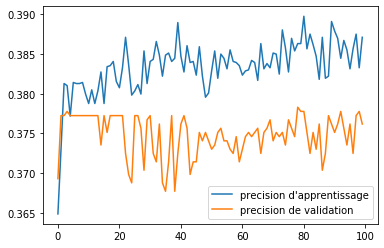

In [32]:
plt.plot(history.history['accuracy'], label = "precision d'apprentissage")
plt.plot(history.history['val_accuracy'], label = 'precision de validation')
plt.legend();

In [22]:
sgd = SGD(lr = 0.001, decay = 1e-6, momentum = 0.9, nesterov = True) 
model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history=model.fit(X_train, Y_train, batch_size = 50, epochs = 150,validation_split = 0.1,verbose = 1) 

Train on 8501 samples, validate on 945 samples
Epoch 1/150
8501/8501 [==============================] - 127s 15ms/step - loss: 1.2700 - accuracy: 0.3904 - val_loss: nan - val_accuracy: 0.1418
Epoch 2/150
8501/8501 [==============================] - 125s 15ms/step - loss: 1.2650 - accuracy: 0.3901 - val_loss: nan - val_accuracy: 0.1418
Epoch 3/150
8501/8501 [==============================] - 128s 15ms/step - loss: 1.2644 - accuracy: 0.3948 - val_loss: nan - val_accuracy: 0.1418
Epoch 4/150
8501/8501 [==============================] - 124s 15ms/step - loss: 1.2646 - accuracy: 0.3885 - val_loss: nan - val_accuracy: 0.1418
Epoch 5/150
8501/8501 [==============================] - 125s 15ms/step - loss: 1.2594 - accuracy: 0.4002 - val_loss: nan - val_accuracy: 0.1418
Epoch 6/150
8501/8501 [==============================] - 123s 14ms/step - loss: 1.2595 - accuracy: 0.4031 - val_loss: nan - val_accuracy: 0.1418
Epoch 7/150
8501/8501 [==============================] - 125s 15ms/step - loss: 1.2

KeyboardInterrupt: 

On trace le graph d'apprentissage pour les échantillons de validation et train 

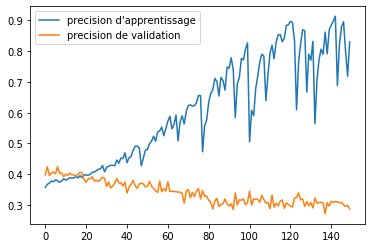

In [14]:
plt.plot(history.history['accuracy'], label = "precision d'apprentissage")
plt.plot(history.history['val_accuracy'], label = 'precision de validation')
plt.legend();

In [21]:
adam = adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(X_train, Y_train, batch_size = 50, epochs = 100, verbose = 1) ;


Epoch 1/100
9446/9446 [==============================] - 173s 18ms/step - loss: 1.3780 - accuracy: 0.3518
Epoch 2/100
9446/9446 [==============================] - 172s 18ms/step - loss: 1.2955 - accuracy: 0.3728
Epoch 3/100
9446/9446 [==============================] - 169s 18ms/step - loss: 1.2881 - accuracy: 0.3791
Epoch 4/100
9446/9446 [==============================] - 171s 18ms/step - loss: 1.2872 - accuracy: 0.3777
Epoch 5/100
9446/9446 [==============================] - 184s 20ms/step - loss: 1.2875 - accuracy: 0.3797
Epoch 6/100
9446/9446 [==============================] - 169s 18ms/step - loss: 1.2873 - accuracy: 0.3788
Epoch 7/100
9446/9446 [==============================] - 164s 17ms/step - loss: 1.2874 - accuracy: 0.3790
Epoch 8/100
9446/9446 [==============================] - 165s 17ms/step - loss: 1.2869 - accuracy: 0.3790
Epoch 9/100
9446/9446 [==============================] - 167s 18ms/step - loss: 1.2872 - accuracy: 0.3805
Epoch 10/100
9446/9446 [=====================

KeyboardInterrupt: 

I'm setting up a Learning Rate Scheduler in Keras, using history loss as an updater to self.model.optimizer.lr, 

Etant donné que le taux d'apprentissage est le paramètre le plus important à regler on fait un algorithm avec le taux variable

In [30]:
# CODE DE https://www.programcreek.com/python/example/104414/keras.callbacks.LearningRateScheduler

from keras.callbacks import LearningRateScheduler

sd=[]
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = [1,1]

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        sd.append(step_decay(len(self.losses)))
        print('lr:', step_decay(len(self.losses)))

epochs = 100
learning_rate = 0.1
decay_rate = 5e-6
momentum = 0.9

sgd = SGD(lr=learning_rate,momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(optimizer=sgd,loss = 'categorical_crossentropy', metrics = ['accuracy'])

def step_decay(losses):
    if float(2*np.sqrt(np.array(history.losses[-1])))<0.3:
        lrate=0.01*1/(1+0.1*len(history.losses))
        momentum=0.9
        decay_rate=2e-6
        return lrate
    else:
        lrate=0.1
        return lrate
history=LossHistory()
lrate=LearningRateScheduler(step_decay)

model.fit(X_train,Y_train, batch_size = 50, nb_epoch=epochs,callbacks=[history,lrate],verbose=2)

C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/100
 - 257s - loss: 1.2887 - accuracy: 0.3747
lr: 0.1
Epoch 2/100
 - 267s - loss: 1.2920 - accuracy: 0.3622
lr: 0.1
Epoch 3/100
 - 251s - loss: 1.2902 - accuracy: 0.3721
lr: 0.1
Epoch 4/100
 - 248s - loss: 1.2910 - accuracy: 0.3610
lr: 0.1
Epoch 5/100
 - 263s - loss: 1.2891 - accuracy: 0.3696
lr: 0.1
Epoch 6/100
 - 254s - loss: 1.2904 - accuracy: 0.3662
lr: 0.1
Epoch 7/100
 - 258s - loss: 1.2904 - accuracy: 0.3720
lr: 0.1
Epoch 8/100
 - 255s - loss: 1.2900 - accuracy: 0.3685
lr: 0.1
Epoch 9/100
 - 256s - loss: 1.2900 - accuracy: 0.3716
lr: 0.1
Epoch 10/100
 - 252s - loss: 1.2903 - accuracy: 0.3748
lr: 0.1
Epoch 11/100
 - 255s - loss: 1.2894 - accuracy: 0.3749
lr: 0.1
Epoch 12/100
 - 255s - loss: 1.2899 - accuracy: 0.3646
lr: 0.1
Epoch 13/100
 - 249s - loss: 1.2884 - accuracy: 0.3795
lr: 0.1
Epoch 14/100
 - 249s - loss: 1.2889 - accuracy: 0.3715
lr: 0.1
Epoch 15/100
 - 250s - loss: 1.2916 - accuracy: 0.3650
lr: 0.1
Epoch 16/100
 - 249s - loss: 1.2898 - accuracy: 0.3703
lr: 0.1
E

KeyboardInterrupt: 

In [27]:
#CODE DE https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/
# learning rate schedule
from keras.callbacks import LearningRateScheduler
def step_decay(epoch):
	initial_lrate = 0.01
	drop = 0.96
	epochs_drop = 20 
	lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
	return lrate
# Compile model
sgd = SGD(lr=0.0, momentum=0.9)
model.compile(loss = 'categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# learning schedule callback
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
# Fit the model
history1=model.fit(X_train, Y_train, batch_size = 50, epochs = 100, callbacks=callbacks_list,validation_split = 0.1, verbose=1) 

Train on 8501 samples, validate on 945 samples
Epoch 1/100
8501/8501 [==============================] - 255s 30ms/step - loss: 1.3529 - accuracy: 0.3593 - val_loss: 1.2792 - val_accuracy: 0.4063
Epoch 2/100
8501/8501 [==============================] - 256s 30ms/step - loss: 1.2961 - accuracy: 0.3741 - val_loss: 1.2786 - val_accuracy: 0.4011
Epoch 3/100
8501/8501 [==============================] - 253s 30ms/step - loss: 1.2918 - accuracy: 0.3673 - val_loss: 1.2750 - val_accuracy: 0.3968
Epoch 4/100
8501/8501 [==============================] - 255s 30ms/step - loss: 1.2903 - accuracy: 0.3717 - val_loss: 1.2756 - val_accuracy: 0.4011
Epoch 5/100
8501/8501 [==============================] - 174s 20ms/step - loss: 1.2893 - accuracy: 0.3740 - val_loss: 1.2763 - val_accuracy: 0.4032
Epoch 6/100
8501/8501 [==============================] - 165s 19ms/step - loss: 1.2864 - accuracy: 0.3812 - val_loss: 1.2759 - val_accuracy: 0.3894
Epoch 7/100
8501/8501 [==============================] - 163s 19m

Epoch 56/100
8501/8501 [==============================] - 174s 21ms/step - loss: 0.9995 - accuracy: 0.5519 - val_loss: 1.4908 - val_accuracy: 0.3111
Epoch 57/100
8501/8501 [==============================] - 158s 19ms/step - loss: 1.0244 - accuracy: 0.5484 - val_loss: 1.5151 - val_accuracy: 0.3354
Epoch 58/100
8501/8501 [==============================] - 158s 19ms/step - loss: 1.2460 - accuracy: 0.4201 - val_loss: 1.3441 - val_accuracy: 0.3630
Epoch 59/100
8501/8501 [==============================] - 158s 19ms/step - loss: 1.1492 - accuracy: 0.4698 - val_loss: 1.4183 - val_accuracy: 0.3735
Epoch 60/100
8501/8501 [==============================] - 160s 19ms/step - loss: 1.0808 - accuracy: 0.5148 - val_loss: 1.4355 - val_accuracy: 0.3460
Epoch 61/100
8501/8501 [==============================] - 163s 19ms/step - loss: 1.2294 - accuracy: 0.4308 - val_loss: 1.3289 - val_accuracy: 0.3841
Epoch 62/100
8501/8501 [==============================] - 170s 20ms/step - loss: 1.1420 - accuracy: 0.4743

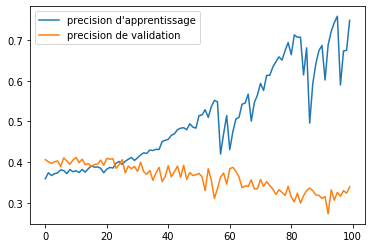

In [28]:
plt.plot(history1.history['accuracy'], label = "precision d'apprentissage")
plt.plot(history1.history['val_accuracy'], label = 'precision de validation')
plt.legend();

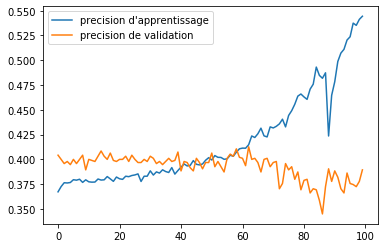

In [21]:
plt.plot(history1.history['accuracy'], label = "precision d'apprentissage")
plt.plot(history1.history['val_accuracy'], label = 'precision de validation')
plt.legend();

# INCEPTION

In [26]:
import keras
from keras.layers.core import Layer
import keras.backend as K
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten

import cv2 
import numpy as np 
#from keras.datasets import cifar10 
from keras import backend as K 
from keras.utils import np_utils

import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler

MODELE AVEC trois MODULES INCEPTION ET FREEZING

In [67]:
#INITIALISATEURS
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

#PREMIERES COUCHES
model=Sequential()
model.add(Conv2D(64, (3,3),trainable=False, padding='same', strides=(2, 2), activation='relu',input_shape=(height, width, 1), kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dropout(0.4))
model.add(MaxPool2D((3, 3), padding='same', strides=(2, 2)))
model.add(Conv2D(64, (1, 1),trainable=False, padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1'))
model.add(Dropout(0.4))
model.add(Conv2D(192, (3, 3),trainable=False, padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1'))
model.add(Dropout(0.4))
model.add(MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2'))

### MODULE INCEPTION
model.add(Conv2D(64, (1, 1),trainable=False,padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))   
model.add(Dropout(0.4))
model.add(Conv2D(96, (1, 1),trainable=False, padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dropout(0.4))
model.add(Conv2D(128, (3, 3),trainable=False, padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dropout(0.4))
model.add(Conv2D(16, (1, 1),trainable=False, padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dropout(0.4))
model.add(Conv2D(32, (5, 5),trainable=False, padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(MaxPool2D((3, 3), strides=(1, 1), padding='same'))
model.add(Conv2D(32, (1, 1),trainable=False,padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))

### MODULE INCEPTION
model.add(Conv2D(256, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))   
model.add(Dropout(0.4))
model.add(Conv2D(160, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dropout(0.4))
model.add(Conv2D(320, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dropout(0.4))
model.add(Conv2D(32, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dropout(0.4))
model.add(Conv2D(128, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(MaxPool2D((3, 3), strides=(1, 1), padding='same'))
model.add(Conv2D(128, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))

### MODULE INCEPTION
model.add(Conv2D(64, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))   
model.add(Dropout(0.4))
model.add(Conv2D(96, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dropout(0.4))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dropout(0.4))
model.add(Conv2D(16, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dropout(0.4))
model.add(Conv2D(32, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(MaxPool2D((3, 3), strides=(1, 1), padding='same'))
model.add(Conv2D(32, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))

#couches finales
model.add(AveragePooling2D((5, 5), strides=3))
model.add(Conv2D(128, (1, 1), padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(4, activation='softmax', name='auxilliary_output_2'))

model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_285 (Conv2D)          (None, 50, 50, 64)        640       
_________________________________________________________________
dropout_127 (Dropout)        (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv_2a_3x3/1 (Conv2D)       (None, 25, 25, 64)        4160      
_________________________________________________________________
dropout_128 (Dropout)        (None, 25, 25, 64)        0         
_________________________________________________________________
conv_2b_3x3/1 (Conv2D)       (None, 25, 25, 192)       110784    
_________________________________________________________________
dropout_129 (Dropout)        (None, 25, 25, 192)     

In [68]:
epochs = 25
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 2
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

#es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)
es_callback=[lr_sc]

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history1=model.fit(X_train, Y_train, batch_size = 50, epochs = 10 ,validation_split = 0.1,callbacks=es_callback,verbose=1) 

Train on 8501 samples, validate on 945 samples
Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
8501/8501 [==============================] - 261s 31ms/step - loss: 1.3109 - accuracy: 0.3667 - val_loss: 1.2794 - val_accuracy: 0.4000
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.0096.
8501/8501 [==============================] - 257s 30ms/step - loss: 1.2909 - accuracy: 0.3763 - val_loss: 1.2790 - val_accuracy: 0.4000
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.0096.
8501/8501 [==============================] - 255s 30ms/step - loss: 1.2896 - accuracy: 0.3741 - val_loss: 1.2789 - val_accuracy: 0.4000
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 0.009216.
8501/8501 [==============================] - 254s 30ms/step - loss: 1.2887 - accuracy: 0.3783 - val_loss: 1.2791 - val_accuracy: 0.4000
Epoch 5/10

Epoch 00005: LearningRateScheduler setting learning rate to 0.009216.
8501/85

# utilisation de pre- trained modèles avec freezing
 # VGG

In [138]:
from keras.applications import VGG16
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, 3))
vgg_conv.layers.pop(0)

In [139]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-1]:
    layer.trainable = False
 
for layer in vgg_conv.layers:
    print(layer, layer.trainable)
print(len(vgg_conv.layers))

#for a in [3,4]:
 #    vgg_conv.layers.pop(a)
#print(len(vgg_conv.layers))
    
# Create the model
model = Sequential()
model.add(Conv2D(3, kernel_size = (3, 3), activation='relu', input_shape=(height, width, 1)))

# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

<keras.layers.convolutional.Conv2D object at 0x0000027DE5AE8D30> False
<keras.layers.convolutional.Conv2D object at 0x0000027DCED89E10> False
<keras.layers.pooling.MaxPooling2D object at 0x0000027DE5AFE978> False
<keras.layers.convolutional.Conv2D object at 0x0000027DE5AFEB38> False
<keras.layers.convolutional.Conv2D object at 0x0000027DE26E2780> False
<keras.layers.pooling.MaxPooling2D object at 0x0000027DE274CF98> False
<keras.layers.convolutional.Conv2D object at 0x0000027DE274C400> False
<keras.layers.convolutional.Conv2D object at 0x0000027DE2717860> False
<keras.layers.convolutional.Conv2D object at 0x0000027D86C307B8> False
<keras.layers.pooling.MaxPooling2D object at 0x0000027DCEDBA160> False
<keras.layers.convolutional.Conv2D object at 0x0000027D902664A8> False
<keras.layers.convolutional.Conv2D object at 0x0000027D903DCDA0> False
<keras.layers.convolutional.Conv2D object at 0x0000027D9039ECC0> False
<keras.layers.pooling.MaxPooling2D object at 0x0000027D0CDF1FD0> False
<keras

In [136]:
sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)
es_callback=[lr_sc]

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history1=model.fit(X_train, Y_train, batch_size = 50, epochs = 3 ,validation_split = 0.1,verbose=1)#,callbacks=es_callback)


Train on 8501 samples, validate on 945 samples
Epoch 1/3
8501/8501 [==============================] - 2885s 339ms/step - loss: nan - accuracy: 0.1602 - val_loss: nan - val_accuracy: 0.1418
Epoch 2/3
8501/8501 [==============================] - 2304s 271ms/step - loss: nan - accuracy: 0.1570 - val_loss: nan - val_accuracy: 0.1418
Epoch 3/3
8501/8501 [==============================] - 1945s 229ms/step - loss: nan - accuracy: 0.1570 - val_loss: nan - val_accuracy: 0.1418


KeyError: 'input_8_ib-0'

 # ResNet50

In [ ]:
from keras.applications import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.optimizers import Adam

In [ ]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)    
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(loss='binary_crossentropy',optimizer=Adam(lr=lr),metrics=['accuracy'])
    return model

resnet = DenseNet201(weights='imagenet', include_top=False,input_shape=(100,100,3))

model = build_model(resnet ,lr = 1e-4)
model.summary()

In [ ]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,verbose=1,factor=0.2, min_lr=1e-7)
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = model.fit(X_TRAIN, Y_train, batch_size=30,steps_per_epoch=x_TRAIN.shape[0] /30,epochs=20,
    validation_split=0.1, callbacks=[learn_control, checkpoint],verbose=1)

# code de stack overflow

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              2561024   
_________________________________________________________________
dropout_32 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_33 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_34 (Dropout)         (None, 256)              

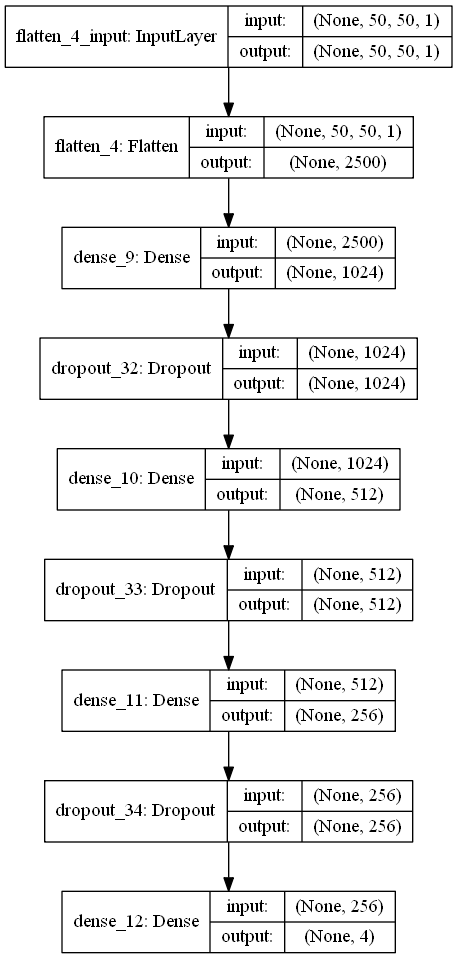

In [29]:
model=Sequential()
model.add(Flatten(input_shape=(height, width, num_channel)))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(4, activation='softmax'))

model.summary()

plot_model(model, show_shapes=True, to_file='Model_Stack.png')

In [31]:
epochs = 25
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.99999
    epochs_drop = 5
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

#es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
sgd = SGD(lr=initial_lrate, momentum=0.9)

lr_sc = LearningRateScheduler(decay, verbose=1)
es_callback=[lr_sc]

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history1=model.fit(X_train, Y_train, batch_size = 50, epochs = 100 ,validation_split = 0.1,verbose=1)#,callbacks=es_callback

Train on 8501 samples, validate on 945 samples
Epoch 1/100
8501/8501 [==============================] - 9s 1ms/step - loss: nan - accuracy: 0.1570 - val_loss: nan - val_accuracy: 0.1418
Epoch 2/100
8501/8501 [==============================] - 7s 847us/step - loss: nan - accuracy: 0.1570 - val_loss: nan - val_accuracy: 0.1418
Epoch 3/100
8501/8501 [==============================] - 8s 920us/step - loss: nan - accuracy: 0.1570 - val_loss: nan - val_accuracy: 0.1418
Epoch 4/100
8501/8501 [==============================] - 7s 835us/step - loss: nan - accuracy: 0.1570 - val_loss: nan - val_accuracy: 0.1418
Epoch 5/100
 600/8501 [=>............................] - ETA: 6s - loss: nan - accuracy: 0.142 - ETA: 6s - loss: nan - accuracy: 0.1367

KeyboardInterrupt: 